# CNN + MaxPool
Fixed train/valid split.
Combine train+test in one. 
Put this in a loop of 10.
Longest, MCC.

In [23]:
from datetime import datetime
print(datetime.now())

2023-03-11 22:24:07.325321


In [24]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [25]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=12
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

Python 3.9.16
sklearn 1.2.1


In [26]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
SEQUENCE_TRAIN = 'train.longest_lncRNA_transcripts.csv'
RCI_FILE_TEST  = 'test.lncRNA_RCI.csv'
SEQUENCE_TEST  = 'test.longest_lncRNA_transcripts.csv'
CNN_FILE       = 'cnn_236.model'
GMM_FILE       = 'gmm_236.pickle'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS      = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [27]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [28]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        gene_to_rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [29]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [30]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-11 22:24:10.629360
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_13 (Conv1D)          (None, 4982, 64)          4160      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 621, 64)          0         
 g1D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 39744)             0         
                                                                 
 dense_26 (Dense)            (None, 16)                635920    
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                          

## Training

In [31]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def _get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index, exclude_middle=False):
        # gene_index is ndarray with subset of indices of all_genes
        subsetX=[]
        subsetY=[]
        gene_subset = self._get_gene_subset(gene_index)
        for t in range(len(self.all_ids)):
            gene_id,tran_id = self.all_ids[t]
            if gene_id in gene_subset:
                oneX            = self.all_seqs[t]
                oneY            = self.rci_map[gene_id]
                if exclude_middle and oneY >= -2 and oneY <= 0:
                    # Exclude middle from train set only, for comparison to Yuan et al
                    continue
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:
                # assume prior call to load_gmm()
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_without_validation(self):
        print(datetime.now())
        # for final train, the train subset is the entire data set
        train_index = range(len(self.all_ids))  
        X_train,y_rci = self._get_X_y(train_index) 
        self._prepare_threshold(y_rci,True)  # create and save
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        y_rci = None
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # validation_data=(X_valid,y_valid) ) 

        # for final train, there is no separate valid set
        X_valid = X_train   
        y_valid = y_train
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_valid, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
        self._show_sizes('Train',y_valid)
        self._show_sizes('Predict',yhat_classes)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_valid, yhat_classes)*100.
        precision = precision_score(y_valid, yhat_classes)*100.
        recall = recall_score(y_valid, yhat_classes)*100.
        f1 = f1_score(y_valid, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
        mcc = matthews_corrcoef(y_valid, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_valid,yhat_pred,prc_X,prc_Y)
        print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
        print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
        print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)
        
    def test_without_training(self):
        print(datetime.now())
        # for final train, the train subset is the entire data set
        train_index = range(len(self.all_ids))  
        X_train,y_rci = self._get_X_y(train_index) 
        self._prepare_threshold(y_rci,False)  # reload
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        y_rci = None
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}

        # for final test, do no train
        # assume load_cnn) has been called

        # for final test, there is no separate valid set
        X_valid = X_train   
        y_valid = y_train
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_valid, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
        self._show_sizes('Train',y_valid)
        self._show_sizes('Predict',yhat_classes)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_valid, yhat_classes)*100.
        precision = precision_score(y_valid, yhat_classes)*100.
        recall = recall_score(y_valid, yhat_classes)*100.
        f1 = f1_score(y_valid, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
        mcc = matthews_corrcoef(y_valid, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_valid,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def load_cnn(self,filename):
        self.model = keras.models.load_model(filename)
        
    def load_gmm(self,filename):
        gmm = pickle.load(open(filename,'rb'))
        self.discriminator = gmm
        
    def save_cnn(self,filename):
        self.model.save(filename)
        
    def save_gmm(self,filename):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            pickle.dump(gmm, open(filename,'wb'))
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

2023-03-11 22:24:10.797817
Loading...
2023-03-11 22:24:10.798385
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4125 sequences.

Training # 0
2023-03-11 22:24:16.985933
2023-03-11 22:24:16.986560
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:24:19.578902
Epoch 1/12
129/129 [==============================] - 4s 12ms/step - loss: 0.7111 - accuracy: 0.4509
Epoch 2/12
129/129 [==============================] - 1s 10ms/step - loss: 0.6957 - accuracy: 0.5319
Epoch 3/12
129/129 [==============================] - 1s 10ms/step - loss: 0.6758 - accuracy: 0.5629
Epoch 4/12
129/129 [==============================] - 1s 10ms/step - loss: 0.6403 - accuracy: 0.6087
Epoch 5/12
129/129 [==============================] - 1s 10ms/step - loss: 0.5580 - accuracy: 0.7067
Epoch 6/12
1

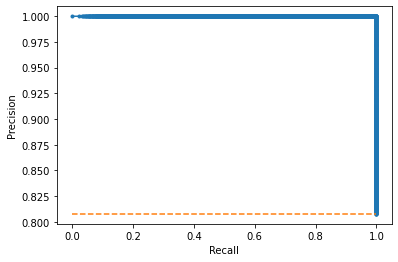

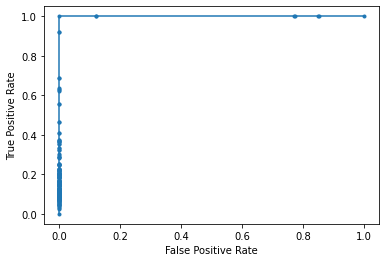

Accuracy: 99.95% Precision: 100.00% Recall: 99.94%
F1: 99.97% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:24:41.552168
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1018 sequences.

Testing # 0
2023-03-11 22:24:43.702540
2023-03-11 22:24:44.098968
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:24:44.359024
train class weights 1:0  0.61: 2.83
Train 1:0 838:180 82.32%
Predict 1:0 785:233 77.11%
Valid sizes (1018, 4997) (1018,)
Range of scores: 3.880962e-11 to 1.0
Score threshold 0.5


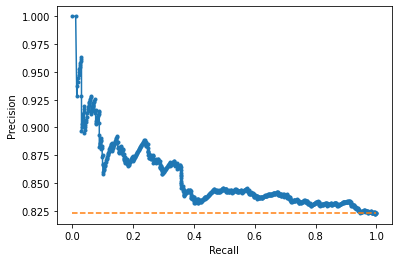

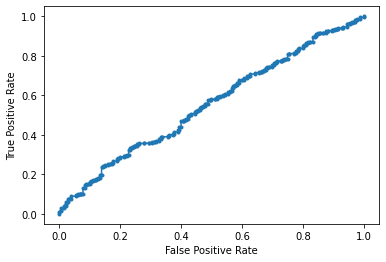

Accuracy: 68.86% Precision: 83.18% Recall: 77.92%
F1: 80.47% MCC: 0.04%
AUPRC: 85.47% AUROC: 55.47%
 accuracy [68.86051080550098]
 precision [83.18471337579618]
 recall [77.9236276849642]
 F1 [80.4682686383241]
 MCC [0.041685595351733225]
 AUPRC [85.47206377505988]
 AUROC [55.47401219835588]
Loading...
2023-03-11 22:24:45.090084
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4125 sequences.

Training # 1
2023-03-11 22:24:52.562350
2023-03-11 22:24:52.563336
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:24:55.240207
Epoch 1/12
129/129 [==============================] - 3s 11ms/step - loss: 0.7101 - accuracy: 0.5006
Epoch 2/12
129/129 [==============================] - 1s 10ms/step - loss: 0.6941 - accuracy: 0.5423
Epoch 3/12
129/129 [=============================

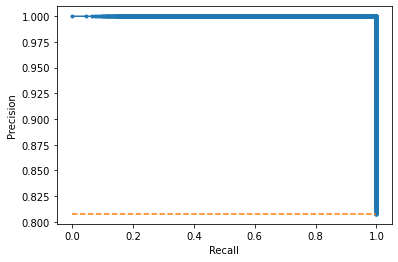

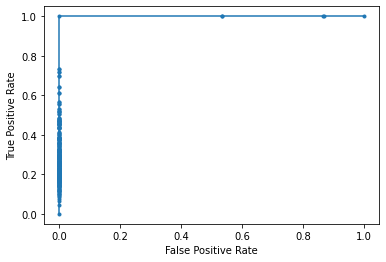

Accuracy: 99.98% Precision: 100.00% Recall: 99.97%
F1: 99.98% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:25:19.049126
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1018 sequences.

Testing # 1
2023-03-11 22:25:20.403322
2023-03-11 22:25:21.147337
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:25:21.422213
train class weights 1:0  0.61: 2.83
Train 1:0 838:180 82.32%
Predict 1:0 870:148 85.46%
Valid sizes (1018, 4997) (1018,)
Range of scores: 0.00012239929 to 1.0
Score threshold 0.5


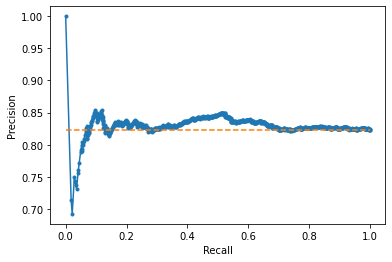

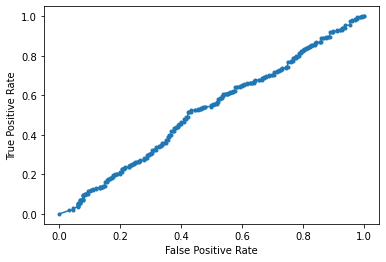

Accuracy: 73.48% Precision: 82.64% Recall: 85.80%
F1: 84.19% MCC: 0.02%
AUPRC: 82.86% AUROC: 52.30%
 accuracy [73.47740667976424]
 precision [82.64367816091955]
 recall [85.79952267303102]
 F1 [84.192037470726]
 MCC [0.020679747447225318]
 AUPRC [82.86275980447806]
 AUROC [52.30243967117475]
Loading...
2023-03-11 22:25:22.031686
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4125 sequences.

Training # 2
2023-03-11 22:25:27.784204
2023-03-11 22:25:27.785497
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:25:32.628428
Epoch 1/12
129/129 [==============================] - 3s 11ms/step - loss: 0.7105 - accuracy: 0.4926
Epoch 2/12
129/129 [==============================] - 1s 10ms/step - loss: 0.6951 - accuracy: 0.5079
Epoch 3/12
129/129 [=============================

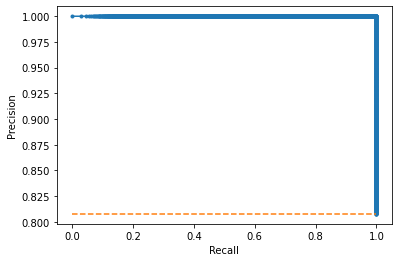

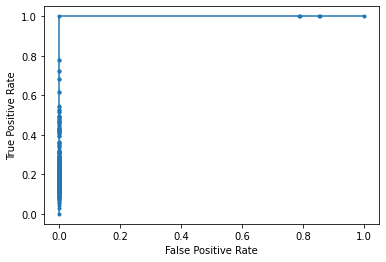

Accuracy: 100.00% Precision: 100.00% Recall: 100.00%
F1: 100.00% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:25:57.391505
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1018 sequences.

Testing # 2
2023-03-11 22:25:59.835070
2023-03-11 22:26:00.241217
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:26:00.502603
train class weights 1:0  0.61: 2.83
Train 1:0 838:180 82.32%
Predict 1:0 844:174 82.91%
Valid sizes (1018, 4997) (1018,)
Range of scores: 1.0266655e-05 to 1.0
Score threshold 0.5


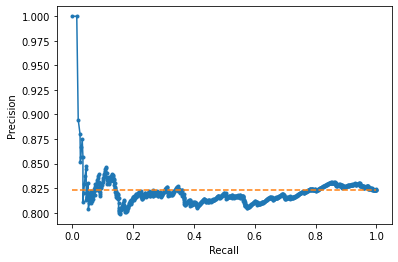

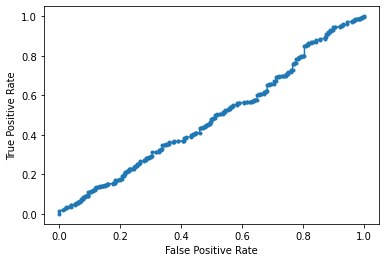

Accuracy: 72.10% Precision: 82.82% Recall: 83.41%
F1: 83.12% MCC: 0.03%
AUPRC: 82.34% AUROC: 48.92%
 accuracy [72.10216110019645]
 precision [82.81990521327015]
 recall [83.4128878281623]
 F1 [83.11533888228301]
 MCC [0.02895830652579689]
 AUPRC [82.34326614555985]
 AUROC [48.92071068682047]
Loading...
2023-03-11 22:26:01.104206
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4125 sequences.

Training # 3
2023-03-11 22:26:06.479411
2023-03-11 22:26:06.480361
Discriminator is GMM
Means [-0.2540669411642016, 1.989108624855973]
Variances [8.04589973 2.55464157]
Priors [0.34916957 0.65083043]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:26:09.065107
Epoch 1/12
129/129 [==============================] - 4s 13ms/step - loss: 0.7164 - accuracy: 0.4885
Epoch 2/12
129/129 [==============================] - 2s 12ms/step - loss: 0.6911 - accuracy: 0.4965
Epoch 3/12
129/129 [=============================

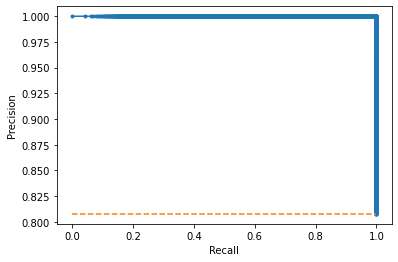

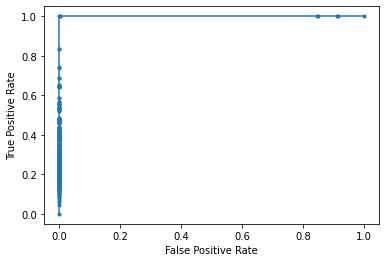

Accuracy: 99.98% Precision: 100.00% Recall: 99.97%
F1: 99.98% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:26:34.176774
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1018 sequences.

Testing # 3
2023-03-11 22:26:35.589218
2023-03-11 22:26:35.993434
Discriminator is GMM
Means [-0.2540669411642016, 1.989108624855973]
Variances [8.04589973 2.55464157]
Priors [0.34916957 0.65083043]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:26:36.266251
train class weights 1:0  0.61: 2.83
Train 1:0 838:180 82.32%
Predict 1:0 892:126 87.62%
Valid sizes (1018, 4997) (1018,)
Range of scores: 3.6862755e-05 to 1.0
Score threshold 0.5


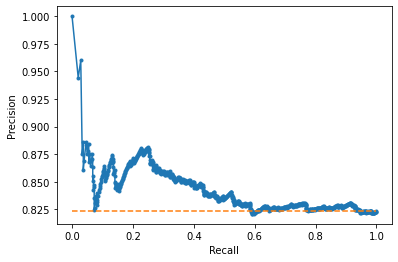

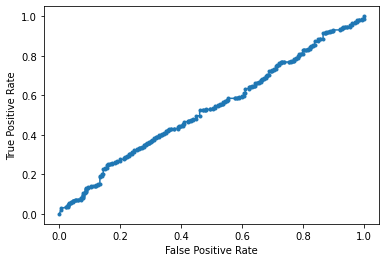

Accuracy: 75.25% Precision: 82.85% Recall: 88.19%
F1: 85.43% MCC: 0.04%
AUPRC: 84.50% AUROC: 53.36%
 accuracy [75.24557956777997]
 precision [82.847533632287]
 recall [88.18615751789977]
 F1 [85.4335260115607]
 MCC [0.03691116943011056]
 AUPRC [84.49694608174372]
 AUROC [53.356536727658444]
Loading...
2023-03-11 22:26:36.878626
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4125 sequences.

Training # 4
2023-03-11 22:26:44.446900
2023-03-11 22:26:44.447884
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:26:48.990551
Epoch 1/12
129/129 [==============================] - 3s 12ms/step - loss: 0.7120 - accuracy: 0.5086
Epoch 2/12
129/129 [==============================] - 1s 11ms/step - loss: 0.6948 - accuracy: 0.5055
Epoch 3/12
129/129 [==============================

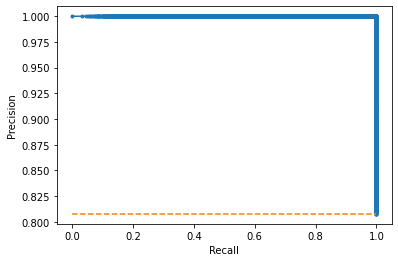

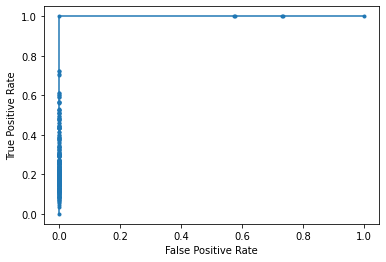

Accuracy: 100.00% Precision: 100.00% Recall: 100.00%
F1: 100.00% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:27:09.708269
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1018 sequences.

Testing # 4
2023-03-11 22:27:11.033526
2023-03-11 22:27:11.425647
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:27:11.688400
train class weights 1:0  0.61: 2.83
Train 1:0 838:180 82.32%
Predict 1:0 859:159 84.38%
Valid sizes (1018, 4997) (1018,)
Range of scores: 8.609641e-05 to 1.0
Score threshold 0.5


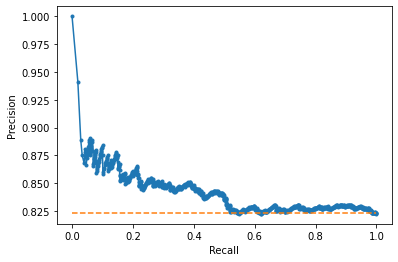

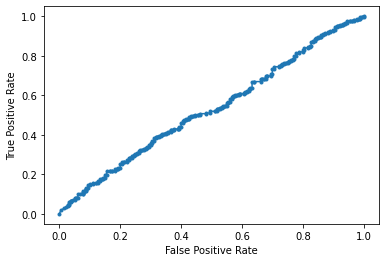

Accuracy: 72.79% Precision: 82.65% Recall: 84.73%
F1: 83.68% MCC: 0.02%
AUPRC: 84.36% AUROC: 53.18%
 accuracy [72.78978388998036]
 precision [82.65424912689173]
 recall [84.7255369928401]
 F1 [83.67707719505009]
 MCC [0.02046908292881033]
 AUPRC [84.36257832518126]
 AUROC [53.1798594537258]
Loading...
2023-03-11 22:27:12.294108
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4125 sequences.

Training # 5
2023-03-11 22:27:18.492925
2023-03-11 22:27:18.494586
Discriminator is GMM
Means [-0.2540669411642016, 1.989108624855973]
Variances [8.04589973 2.55464157]
Priors [0.34916957 0.65083043]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:27:24.454403
Epoch 1/12
129/129 [==============================] - 3s 11ms/step - loss: 0.7118 - accuracy: 0.5079
Epoch 2/12
129/129 [==============================] - 1s 11ms/step - loss: 0.6983 - accuracy: 0.5161
Epoch 3/12
129/129 [==============================

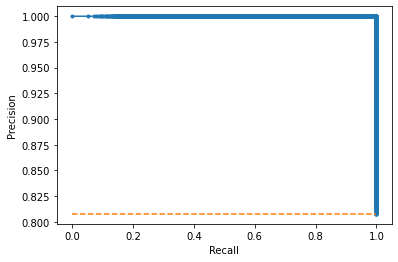

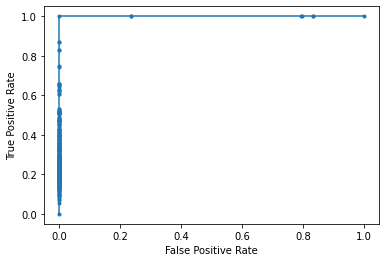

Accuracy: 99.98% Precision: 100.00% Recall: 99.97%
F1: 99.98% MCC: 1.00%
AUPRC: 100.00% AUROC: 99.99%



Loading...
2023-03-11 22:27:45.486015
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1018 sequences.

Testing # 5
2023-03-11 22:27:46.884121
2023-03-11 22:27:47.287131
Discriminator is GMM
Means [-0.2540669411642016, 1.989108624855973]
Variances [8.04589973 2.55464157]
Priors [0.34916957 0.65083043]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:27:47.568984
train class weights 1:0  0.61: 2.83
Train 1:0 838:180 82.32%
Predict 1:0 893:125 87.72%
Valid sizes (1018, 4997) (1018,)
Range of scores: 2.6502243e-05 to 1.0
Score threshold 0.5


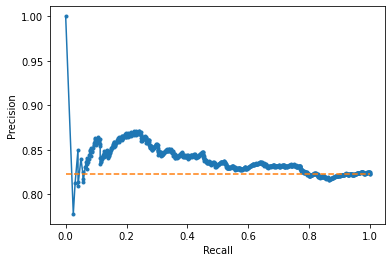

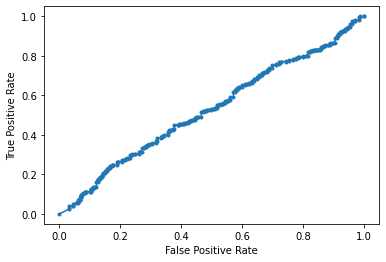

Accuracy: 73.38% Precision: 81.75% Recall: 87.11%
F1: 84.34% MCC: -0.04%
AUPRC: 83.86% AUROC: 52.82%
 accuracy [73.37917485265226]
 precision [81.74692049272116]
 recall [87.11217183770883]
 F1 [84.34430964760253]
 MCC [-0.04002791302729909]
 AUPRC [83.85934667472034]
 AUROC [52.82484752055158]
Loading...
2023-03-11 22:27:48.339285
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4125 sequences.

Training # 6
2023-03-11 22:27:57.296942
2023-03-11 22:27:57.297950
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:27:59.924532
Epoch 1/12
129/129 [==============================] - 3s 12ms/step - loss: 0.7093 - accuracy: 0.4827
Epoch 2/12
129/129 [==============================] - 2s 12ms/step - loss: 0.6959 - accuracy: 0.5328
Epoch 3/12
129/129 [==========================

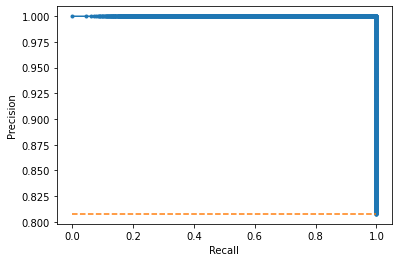

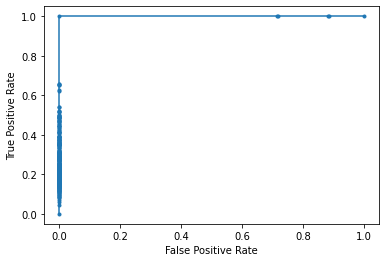

Accuracy: 99.95% Precision: 100.00% Recall: 99.94%
F1: 99.97% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:28:25.337624
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1018 sequences.

Testing # 6
2023-03-11 22:28:26.741569
2023-03-11 22:28:27.172353
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:28:27.434271
train class weights 1:0  0.61: 2.83
Train 1:0 838:180 82.32%
Predict 1:0 859:159 84.38%
Valid sizes (1018, 4997) (1018,)
Range of scores: 3.4555443e-09 to 1.0
Score threshold 0.5


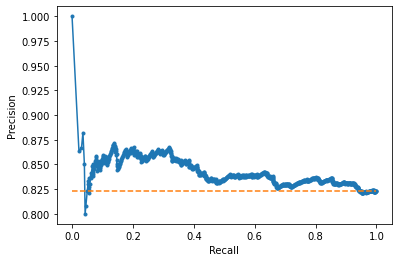

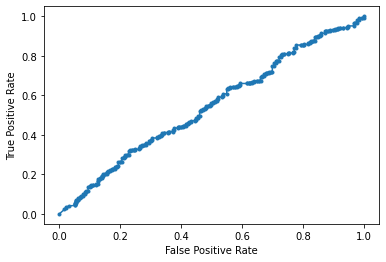

Accuracy: 73.97% Precision: 83.35% Recall: 85.44%
F1: 84.38% MCC: 0.06%
AUPRC: 84.41% AUROC: 54.42%
 accuracy [73.96856581532415]
 precision [83.35273573923166]
 recall [85.44152744630071]
 F1 [84.38420742486741]
 MCC [0.06302359570252493]
 AUPRC [84.4115264555777]
 AUROC [54.42356138955184]
Loading...
2023-03-11 22:28:28.075054
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4125 sequences.

Training # 7
2023-03-11 22:28:35.513319
2023-03-11 22:28:35.514296
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:28:38.168502
Epoch 1/12
129/129 [==============================] - 3s 11ms/step - loss: 0.7142 - accuracy: 0.5076
Epoch 2/12
129/129 [==============================] - 1s 11ms/step - loss: 0.6960 - accuracy: 0.4701
Epoch 3/12
129/129 [=============================

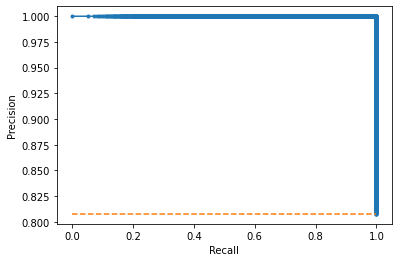

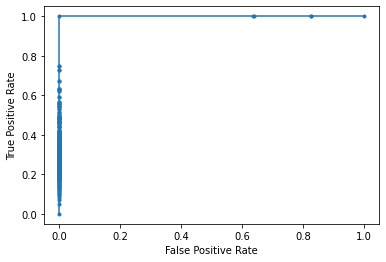

Accuracy: 99.98% Precision: 99.97% Recall: 100.00%
F1: 99.98% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:29:01.147146
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1018 sequences.

Testing # 7
2023-03-11 22:29:02.670419
2023-03-11 22:29:03.078767
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:29:03.344878
train class weights 1:0  0.61: 2.83
Train 1:0 838:180 82.32%
Predict 1:0 918:100 90.18%
Valid sizes (1018, 4997) (1018,)
Range of scores: 6.0667758e-06 to 1.0
Score threshold 0.5


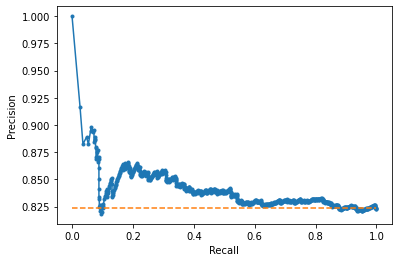

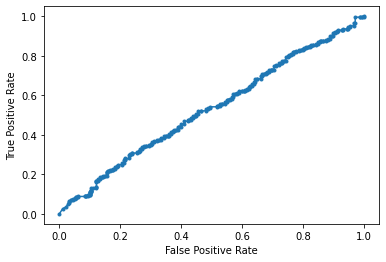

Accuracy: 76.03% Precision: 82.35% Recall: 90.21%
F1: 86.10% MCC: 0.00%
AUPRC: 84.31% AUROC: 53.18%
 accuracy [76.03143418467585]
 precision [82.35294117647058]
 recall [90.21479713603819]
 F1 [86.10478359908883]
 MCC [0.0027533752722037437]
 AUPRC [84.31273552215069]
 AUROC [53.18383717846725]
Loading...
2023-03-11 22:29:03.965063
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4125 sequences.

Training # 8
2023-03-11 22:29:09.334614
2023-03-11 22:29:09.337493
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:29:13.447826
Epoch 1/12
129/129 [==============================] - 3s 12ms/step - loss: 0.7033 - accuracy: 0.5081
Epoch 2/12
129/129 [==============================] - 1s 11ms/step - loss: 0.6933 - accuracy: 0.5462
Epoch 3/12
129/129 [==========================

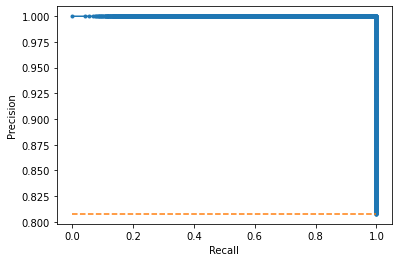

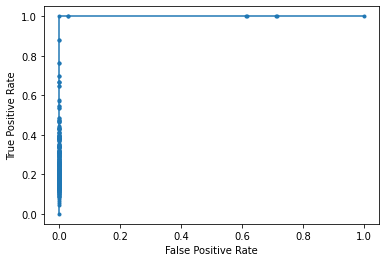

Accuracy: 99.98% Precision: 100.00% Recall: 99.97%
F1: 99.98% MCC: 1.00%
AUPRC: 100.00% AUROC: 100.00%



Loading...
2023-03-11 22:29:37.884017
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1018 sequences.

Testing # 8
2023-03-11 22:29:39.930977
2023-03-11 22:29:40.508719
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:29:40.991574
train class weights 1:0  0.61: 2.83
Train 1:0 838:180 82.32%
Predict 1:0 875:143 85.95%
Valid sizes (1018, 4997) (1018,)
Range of scores: 2.1822582e-07 to 1.0
Score threshold 0.5


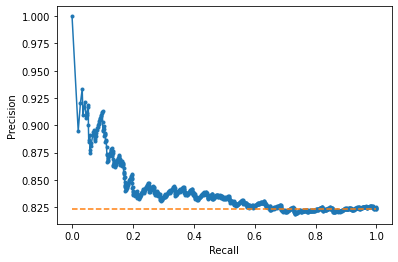

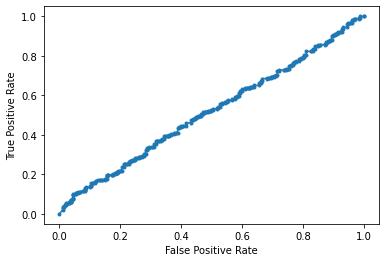

Accuracy: 72.79% Precision: 82.06% Recall: 85.68%
F1: 83.83% MCC: -0.02%
AUPRC: 84.13% AUROC: 51.88%
 accuracy [72.78978388998036]
 precision [82.05714285714286]
 recall [85.68019093078759]
 F1 [83.82953882078226]
 MCC [-0.016930874997529648]
 AUPRC [84.12858420525497]
 AUROC [51.87549721559268]
Loading...
2023-03-11 22:29:41.868727
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4125 sequences.

Training # 9
2023-03-11 22:29:47.498057
2023-03-11 22:29:47.499033
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-11 22:29:50.195952
Epoch 1/12
129/129 [==============================] - 3s 12ms/step - loss: 0.7140 - accuracy: 0.4972
Epoch 2/12
129/129 [==============================] - 1s 11ms/step - loss: 0.6943 - accuracy: 0.5173
Epoch 3/12
129/129 [=========================

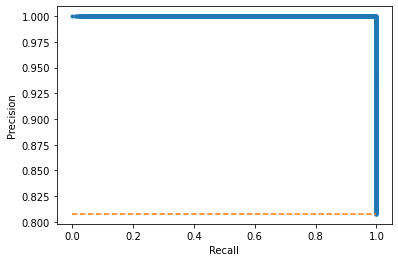

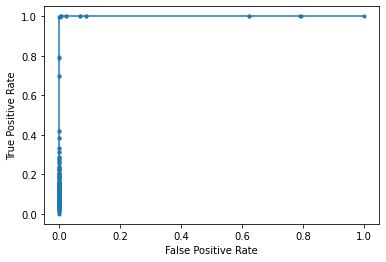

Accuracy: 99.22% Precision: 100.00% Recall: 99.04%
F1: 99.52% MCC: 0.98%
AUPRC: 100.00% AUROC: 99.99%



Loading...
2023-03-11 22:30:11.899127
Number of RCI values loaded 1096
Num RCI: 1096
Load sequence...
Loaded 1018 sequences.

Testing # 9
2023-03-11 22:30:13.237536
2023-03-11 22:30:13.647712
Discriminator is GMM
Means [1.989108624855973, -0.2540669411642016]
Variances [2.55464157 8.04589973]
Priors [0.65083043 0.34916957]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
PREDICT
2023-03-11 22:30:13.919143
train class weights 1:0  0.61: 2.83
Train 1:0 838:180 82.32%
Predict 1:0 771:247 75.74%
Valid sizes (1018, 4997) (1018,)
Range of scores: 1.8684059e-08 to 1.0
Score threshold 0.5


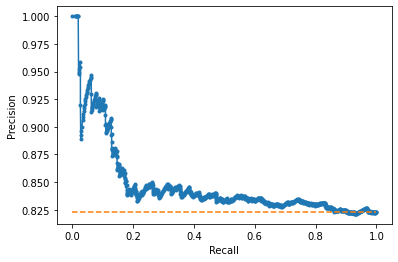

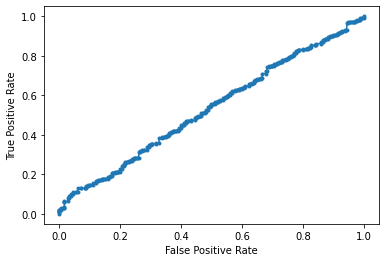

Accuracy: 67.88% Precision: 83.14% Recall: 76.49%
F1: 79.68% MCC: 0.04%
AUPRC: 84.83% AUROC: 53.36%
 accuracy [67.87819253438114]
 precision [83.13878080415046]
 recall [76.49164677804295]
 F1 [79.67681789931635]
 MCC [0.03799723018869969]
 AUPRC [84.8266790748222]
 AUROC [53.36382922301777]
2023-03-11 22:30:14.667955


In [32]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

for repeats in range(10):
    print("Loading...")
    print(datetime.now())
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TRAIN
    gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_TRAIN
    allids,allseq = loader.load_sequence(filepath)
    print('Loaded',len(allseq),'sequences.')
    loader = None  # drop K-mer cache to save RAM
    print()
    print("Training #",repeats)
    print(datetime.now())
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
    cvdo.train_without_validation()
    filepath = DATA_DIR+GMM_FILE
    cvdo.save_gmm(filepath)
    filepath = DATA_DIR+CNN_FILE
    cvdo.save_cnn(filepath)

    print()
    print("Loading...")
    print(datetime.now())
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_TEST
    allids,allseq = loader.load_sequence(filepath)
    print('Loaded',len(allseq),'sequences.')
    loader = None  # drop K-mer cache to save RAM

    print()
    print("Testing #",repeats)
    print(datetime.now())
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
    filepath = DATA_DIR+GMM_FILE
    cvdo.load_gmm(filepath)
    filepath = DATA_DIR+CNN_FILE
    cvdo.load_cnn(filepath)
    cvdo.test_without_training()
    cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
        cvdo.get_statistics()

    print(" accuracy" ,  cv_accuracy)
    print(" precision" , cv_precision)
    print(" recall" ,    cv_recall)
    print(" F1" ,        cv_f1)
    print(" MCC" ,       cv_mcc)
    print(" AUPRC" ,     cv_auprc)
    print(" AUROC" ,     cv_auroc)

    accuracy.append(cv_accuracy)
    precision.append(cv_precision)
    recall.append(cv_recall)
    f1.append(cv_f1)
    mcc.append(cv_mcc)
    auprc.append(cv_auprc)
    auroc.append(cv_auroc)
print(datetime.now())

In [33]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 72.65% std 2.55
 precision mean 82.68% std 0.51
 recall mean 84.50% std 4.29
 F1 mean 83.52% std 2.02
 MCC mean 0.02% std 0.03
 AUPRC mean 84.11% std 0.91
 AUROC mean 52.89% std 1.72
 accuracy [[68.86051080550098], [73.47740667976424], [72.10216110019645], [75.24557956777997], [72.78978388998036], [73.37917485265226], [73.96856581532415], [76.03143418467585], [72.78978388998036], [67.87819253438114]]
 precision [[83.18471337579618], [82.64367816091955], [82.81990521327015], [82.847533632287], [82.65424912689173], [81.74692049272116], [83.35273573923166], [82.35294117647058], [82.05714285714286], [83.13878080415046]]
 recall [[77.9236276849642], [85.79952267303102], [83.4128878281623], [88.18615751789977], [84.7255369928401], [87.11217183770883], [85.44152744630071], [90.21479713603819], [85.68019093078759], [76.49164677804295]]
 F1 [[80.4682686383241], [84.192037470726], [83.11533888228301], [85.4335260115607], [83.67707719505009], [84.34430964760253], [84.38420742486741